In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from sklearn.metrics import accuracy_score, precision_score
import sys
sys.path.append('../')
from utils import invert, to_dense, sum
from datasets import NetflixData, NetflixGenreCastData, MovieLensData, MovieLensUserData
import pickle
import pandas as pd
import os
import missingno as msno
from itertools import chain

root = os.path.abspath("D:/OneDrive - Singapore Management University/datasets/")

# df_imdb

In [224]:
df_imdb = pd.read_table(os.path.join(root, "imdb", "title.basics.tsv", "data.tsv"), delimiter='\t', header=0)
display(df_imdb)

C:\Users\nieht\AppData\Local\Temp\ipykernel_29636\818886752.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_imdb = pd.read_table(os.path.join(root, "imdb", "title.basics.tsv", "data.tsv"), delimiter='\t', header=0)


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"
...,...,...,...,...,...,...,...,...,...
10080280,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2009,\N,\N,"Action,Drama,Family"
10080281,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,\N,\N,"Action,Drama,Family"
10080282,tt9916852,tvEpisode,Episode #3.20,Episode #3.20,0,2010,\N,\N,"Action,Drama,Family"
10080283,tt9916856,short,The Wind,The Wind,0,2015,\N,27,Short


In [150]:
# title.crew.tsv will put directors into writers

df_imdb_crew = pd.read_table(os.path.join(root, "imdb", "title.crew.tsv", "data.tsv"), delimiter='\t', header=0)
display(df_imdb_crew)

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,\N
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N
...,...,...,...
10080280,tt9916848,nm1485677,"nm9187127,nm1485677,nm9826385,nm9299459,nm1628284"
10080281,tt9916850,nm1485677,"nm9187127,nm1485677,nm9826385,nm1628284"
10080282,tt9916852,nm1485677,"nm9187127,nm1485677,nm9826385,nm9299459,nm1628284"
10080283,tt9916856,nm10538645,nm6951431


In [225]:
df_imdb_cast = pd.read_table(os.path.join(root, "imdb", "title.principals.tsv", "data.tsv"), delimiter='\t', header=0)
display(df_imdb_cast['category'].unique()[1:])
display(df_imdb_cast)

array(['director', 'cinematographer', 'composer', 'producer', 'editor',
       'actor', 'actress', 'writer', 'production_designer',
       'archive_footage', 'archive_sound'], dtype=object)

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N
...,...,...,...,...,...,...
57680346,tt9916880,5,nm0584014,director,\N,\N
57680347,tt9916880,6,nm0996406,director,principal director,\N
57680348,tt9916880,7,nm1482639,writer,\N,\N
57680349,tt9916880,8,nm2586970,writer,books,\N


# df_25m_imdb

In [226]:
df_25m_imdb = pd.read_table(os.path.join(root, "ml-imdb", "ml-25m", "movie_ml_imdb.csv"), delimiter='\t', header=0)
# df_25m_imdb['imdb_id'] = df_25m_imdb['imdb_id'].apply(lambda x: x.split('/'))
display(df_25m_imdb)

,movieId,title,genres_ml,year,tconst,writer,actor,director,producer,actress,...,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres_imdb,directors,writers
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,tt0114709,nm0169505|nm0230032|nm0004056|nm0710020|nm0923736,nm0000158|nm0000741|nm0725543|nm0001815,nm0005124,\N,\N,...,movie,Toy Story,Toy Story,0,1995,\N,81,Adventure|Animation|Comedy,nm0005124,nm0005124|nm0230032|nm0004056|nm0710020|nm0923...
1,2,Jumanji,Adventure|Children|Fantasy,1995,tt0113497,nm0378144|nm0852430|nm0833164|nm0885575,nm0000245|nm0404993,nm0002653,nm0472256,nm0000379|nm0001372,...,movie,Jumanji,Jumanji,0,1995,\N,104,Adventure|Comedy|Family,nm0002653,nm0378144|nm0852430|nm0833164|nm0885575
2,3,Grumpier Old Men,Comedy|Romance,1995,tt0113228,nm0425756,nm0000527|nm0000493,nm0222043,nm0075828|nm0204862,nm0000268|nm0000047,...,movie,Grumpier Old Men,Grumpier Old Men,0,1995,\N,101,Comedy|Romance,nm0222043,nm0425756
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995,tt0114885,nm0573334|nm0060103,\N,nm0001845,nm0771834|nm0842470,nm0001365|nm0000291|nm0222643|nm0005375,...,movie,Waiting to Exhale,Waiting to Exhale,0,1995,\N,124,Comedy|Drama|Romance,nm0001845,nm0573334|nm0060103
4,5,Father of the Bride Part II,Comedy,1995,tt0113041,nm0352443|nm0329304|nm0583600,nm0000188|nm0001737,nm0796124,\N,nm0000473|nm0931090,...,movie,Father of the Bride Part II,Father of the Bride Part II,0,1995,\N,106,Comedy|Family|Romance,nm0796124,nm0352443|nm0329304|nm0583600|nm0796124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62418,209157,We,Drama,2018,tt6671244,nm1818234,nm9400914|nm7904438,nm1415482,nm1761379,nm9547544|nm9560986,...,movie,Wij,Wij,0,2018,\N,100,Drama,nm1415482,nm1415482|nm1818234
62419,209159,Window of the Soul,Documentary,2001,tt0297986,\N,\N,nm1065588|nm0142504,nm0848542,\N,...,movie,Window of the Soul,Janela da Alma,0,2001,\N,73,Documentary,nm0142504|nm1065588,nm0142504|nm1065588
62420,209163,Bad Poems,Comedy|Drama,2018,tt6755366,\N,nm2520391|nm0468514,\N,nm2726042,nm6331240|nm0847744,...,movie,Bad Poems,Rossz versek,0,2018,\N,97,Comedy|Drama,nm2520391,nm2520391
62421,209169,A Girl Thing,(no genres listed),2001,tt0249603,\N,\N,nm0003022,nm0076184,nm0001009|nm0000330|nm0000360|nm0001201,...,tvMovie,A Girl Thing,A Girl Thing,0,2001,\N,237,Comedy|Drama|Romance,nm0003022,nm0003022


# test

In [ ]:
nf = NetflixData(full=False)
nf.load()
nf.factor_info

[(array([   0,    1,    2, ..., 9977, 9978, 9979]),
  array([1478381, 1045221,  811218, ..., 1006729,  609169, 2577021]),
  array(['1478381', '1045221', '811218', ..., '1006729', '609169',
         '2577021'], dtype='<U21')),
 (array([   0,    1,    2, ..., 3359, 3360, 3361]),
  array([    3,     9,    17, ..., 17753, 17762, 17765]),
  array(['Character', "Class of Nuke 'Em High 2", '7 Seconds', ...,
         'Maslin Beach', 'Gattaca', "Godzilla's Revenge"], dtype='<U70'))]

In [ ]:
nfgc = NetflixGenreCastData(full=False, source='imdb')
nfgc.load()

[(array([   0,    1,    2, ..., 9989, 9990, 9991]),
  array([2567280, 1478381, 1045221, ..., 2577021, 1541139,  609169]),
  array(['2567280', '1478381', '1045221', ..., '2577021', '1541139',
         '609169'], dtype='<U21')),
 (array([   0,    1,    2, ..., 4942, 4943, 4944]),
  array([    2,     3,     9, ..., 17762, 17765, 17767]),
  array(['Isle of Man TT 2004 Review', 'Character',
         "Class of Nuke 'Em High 2", ..., 'Gattaca', "Godzilla's Revenge",
         'Fidel Castro: American Experience'], dtype='<U98')),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
  array(['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy',
         'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
         'Game-Show', 'History', 'Horror', 'Music', 'Mus

In [99]:
data = MovieLensData(size='100k')
data.load(overwrite_cache=True)
data.X

<943x1682 sparse matrix of type '<class 'numpy.intc'>'
	with 100000 stored elements in Compressed Sparse Row format>

In [100]:
data = MovieLensData(size='1m')
data.load(overwrite_cache=True)
data.X

<6040x3706 sparse matrix of type '<class 'numpy.intc'>'
	with 1000209 stored elements in Compressed Sparse Row format>

In [101]:
data.__dict__

{'X': <6040x3706 sparse matrix of type '<class 'numpy.intc'>'
 	with 1000209 stored elements in Compressed Sparse Row format>,
 'Xs': None,
 'factors': None,
 'factor_info': [(array([   0,    1,    2, ..., 6037, 6038, 6039]),
   array([   1,    2,    3, ..., 6038, 6039, 6040]),
   array(['1', '2', '3', ..., '6038', '6039', '6040'], dtype='<U11')),
  (array([   0,    1,    2, ..., 3703, 3704, 3705]),
   array([   1,    2,    3, ..., 3950, 3951, 3952]),
   array(['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)',
          ..., 'Tigerland (2000)', 'Two Family House (2000)',
          'Contender, The (2000)'], dtype='<U82'))],
 'is_single': True,
 'name': 'ml_1m',
 'root': 'D:\\OneDrive - Singapore Management University\\datasets',
 'cache_path': 'D:\\OneDrive - Singapore Management University\\cache',
 'pickle_path': 'D:\\OneDrive - Singapore Management University\\cache\\ml_1m.pickle',
 'size': '1m',
 'df_ratings':           uid   iid  rating           timestamp  row_idx  

In [102]:
ml_100k_user = MovieLensUserData(size='100k')
ml_100k_user.load(overwrite_cache=True)
ml_100k_user.Xs

[<943x1682 sparse matrix of type '<class 'numpy.intc'>'
 	with 100000 stored elements in Compressed Sparse Row format>,
 <943x81 sparse matrix of type '<class 'numpy.float64'>'
 	with 3499 stored elements in Compressed Sparse Row format>]

In [96]:
ml_1m_user = MovieLensUserData(size='1m')
ml_1m_user.load(overwrite_cache=True)
ml_1m_user.Xs

[<6040x3706 sparse matrix of type '<class 'numpy.intc'>'
 	with 1000209 stored elements in Compressed Sparse Row format>,
 <6040x82 sparse matrix of type '<class 'numpy.float64'>'
 	with 22451 stored elements in Compressed Sparse Row format>]

In [103]:
from datasets import MovieLensGenreCastData
data = MovieLensGenreCastData(size='100k')
data.load(overwrite_cache=True)
data.Xs

[<943x1682 sparse matrix of type '<class 'numpy.intc'>'
 	with 100000 stored elements in Compressed Sparse Row format>,
 <26x1682 sparse matrix of type '<class 'numpy.float64'>'
 	with 4031 stored elements in Compressed Sparse Row format>,
 <4708x1682 sparse matrix of type '<class 'numpy.float64'>'
 	with 8306 stored elements in Compressed Sparse Row format>]

In [104]:
from datasets import MovieLensGenreCastData
data = MovieLensGenreCastData(size='1m')
data.load(overwrite_cache=True)
data.Xs

[<6040x3706 sparse matrix of type '<class 'numpy.intc'>'
 	with 1000209 stored elements in Compressed Sparse Row format>,
 <41x3706 sparse matrix of type '<class 'numpy.float64'>'
 	with 8946 stored elements in Compressed Sparse Row format>,
 <9488x3706 sparse matrix of type '<class 'numpy.float64'>'
 	with 18382 stored elements in Compressed Sparse Row format>]

In [111]:
from datasets import MovieLensGenreCastUserData
data = MovieLensGenreCastUserData(size='100k')
data.load(overwrite_cache=True)
data.Xs

[<943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 100000 stored elements in Compressed Sparse Row format>,
 <943x81 sparse matrix of type '<class 'numpy.float64'>'
 	with 3499 stored elements in Compressed Sparse Row format>,
 <26x1682 sparse matrix of type '<class 'numpy.float64'>'
 	with 4031 stored elements in Compressed Sparse Row format>,
 <4708x1682 sparse matrix of type '<class 'numpy.float64'>'
 	with 8306 stored elements in Compressed Sparse Row format>]

In [112]:
data.factors

[[0, 1], [0, 2], [3, 1], [4, 1]]

In [114]:
len(data.factor_info)

5

In [116]:
data.X

<5677x1763 sparse matrix of type '<class 'numpy.float64'>'
	with 115836 stored elements in List of Lists format>

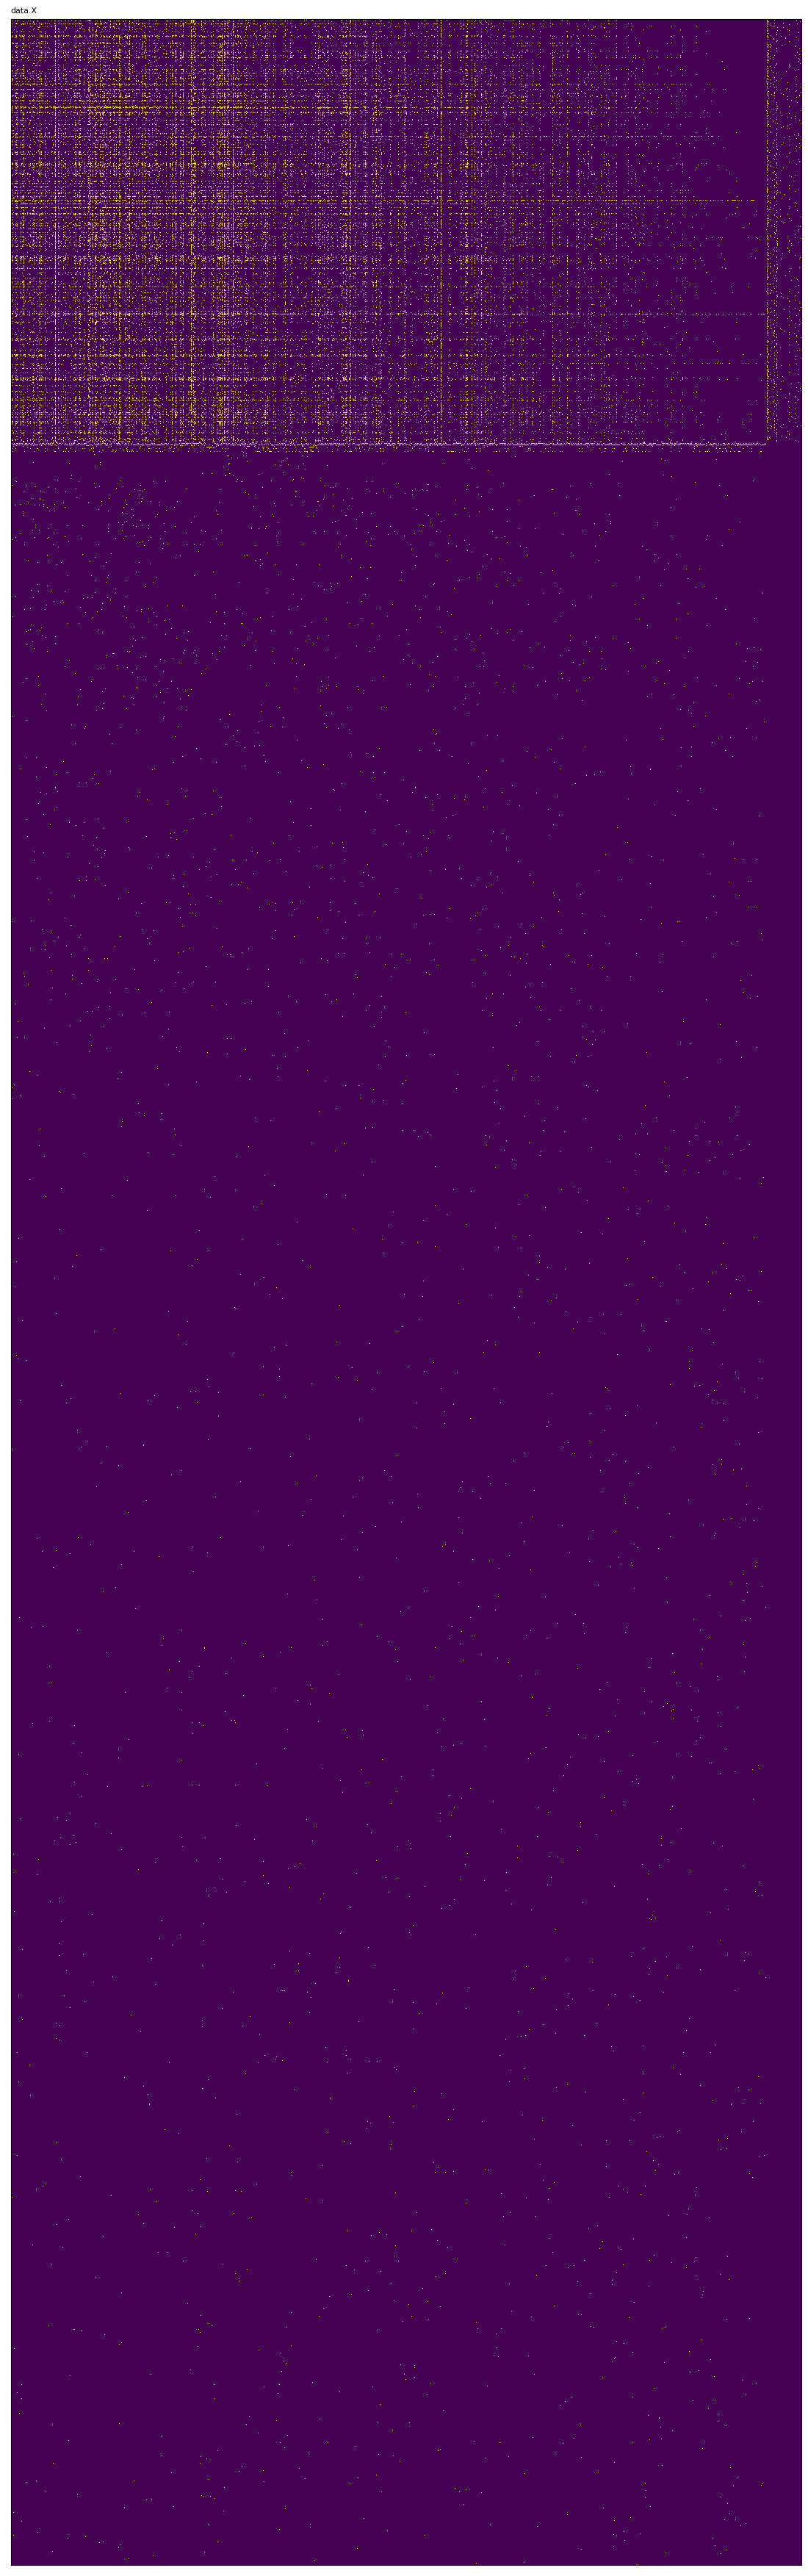

In [119]:
from utils import show_matrix

show_matrix(settings=[(data.X.toarray(), [0, 0], 'data.X')], scaling=3)